This notebook simulates a simple epsilon greedy Mulit-Armed Bandit (MAB) algorithm. We start with a random startegy to familiarize ourselves with the code and metrics, and then move onto a epsilon-greedy strategy.

The code focuses on being illustrative over being efficient.

In [7]:
import random, numpy as np
from scipy.optimize import linprog
advt_ctr = {'A': 0.8, 'B': 0.7, 'C': 0.1, 'D': 0.01}

In [29]:
num_impressions = 100

In [31]:
B_eq = np.zeros((1,1))
B_eq[0, 0] = num_impressions

In [33]:
B_eq

array([[100.]])

In [37]:
temp = list(advt_ctr.items())
c = [-i[1] for i in temp]
A_eq = np.ones(len(advt_ctr)).reshape(1, -1)
B_eq = np.zeros((1,1))
B_eq[0, 0] = num_impressions
res = linprog(c, A_eq=A_eq, b_eq=B_eq)
print(f"Best # of impressions per advt, for a total of {num_impressions} impressions.")
for i, j in zip(res['x'], temp):
    print(f'advt:{j[0]} (ctr={j[1]}), optimal impressions: {int(round(i))}')
int(round(-1*res['fun']))

Best # of impressions per advt, for a total of 100 impressions.
advt:A (ctr=0.8), optimal impressions: 100
advt:B (ctr=0.7), optimal impressions: 0
advt:C (ctr=0.1), optimal impressions: 0
advt:D (ctr=0.01), optimal impressions: 0


In [48]:
res

     con: array([2.92004643e-10])
     fun: -79.99999999975442
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1.00000000e+02, 8.72565756e-11, 4.16635647e-13, 3.77018904e-12])

In [50]:
import random, numpy as np
from scipy.optimize import linprog

# We assume these are the advts and their CTRs. In practice we don't know the actual CTRs and we need to discover them with
# experimentation - thats the whole point of the MAB.
advt_ctr = {'A': 0.8, 'B': 0.7, 'C': 0.1, 'D': 0.01}

# this is a simulator for "users" - feed a advt, receive a click (True) or no-click (False) response
def show_advt_to_user(advt_id):
    ctr = advt_ctr[advt_id]
    if random.random() <=ctr:
        return True
    else:
        return False

print(show_advt_to_user('C'))    
    
def optimal_number_of_clicks(num_impressions):
    """
    While linear programming is technically the correct way to formulate this problem, it is easy to argue by contradiction 
    that the best solution only has the advt with the highest ctr. In any case, this introduces Linear Progamming using scipy.
    
    The LP formulation: 
        maximize ctr_1 * impr_1 + ctr_2 * impr_2 + ....
        constraint: impr_1 + impr_2 + ... = num_impressions
    
    """
    temp = list(advt_ctr.items())
    c = [-i[1] for i in temp]
    A_eq = np.ones(len(advt_ctr)).reshape(1, -1)
    B_eq = np.zeros((1,1))
    B_eq[0, 0] = num_impressions
    res = linprog(c, A_eq=A_eq, b_eq=B_eq)
    print(f"Best # of impressions per advt, for a total of {num_impressions} impressions.")
    for i, j in zip(res['x'], temp):
        print(f'advt:{j[0]} (ctr={j[1]}), optimal impressions: {int(round(i))}')
    return int(round(-1*res['fun']))

print(f"Optimal # of clicks {optimal_number_of_clicks(500)}.")

False
Best # of impressions per advt, for a total of 500 impressions.
advt:A (ctr=0.8), optimal impressions: 500
advt:B (ctr=0.7), optimal impressions: 0
advt:C (ctr=0.1), optimal impressions: 0
advt:D (ctr=0.01), optimal impressions: 0
Optimal # of clicks 400.


After 1000 impressions...


C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\3838344893.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ctr_df=ctr_df.append({'advt': k, 'ctr': advt_ctr[k], 'ctr_type': 'actual'}, ignore_index=True)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\3838344893.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ctr_df=ctr_df.append({'advt': k, 'ctr': empirical_ctr.get(k, 0.0), 'ctr_type': 'empirical'}, ignore_index=True)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\3838344893.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ctr_df=ctr_df.append({'advt': k, 'ctr': advt_ctr[k], 'ctr_type': 'actual'}, ignore_index=True)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\3838344893.py:28: FutureWarning

<AxesSubplot:xlabel='advt', ylabel='ctr'>

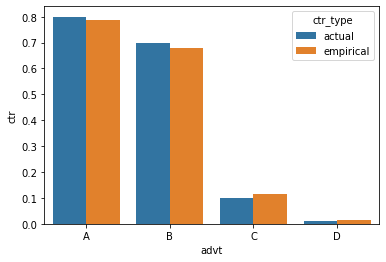

In [55]:
# lets play around with the user simulator a bit, and see if we can recover the actual CTR with a finite number of trials.
from collections import defaultdict
import pandas as pd, seaborn as sns

# number of impressions
n = 1000

# we will record the number of clicks each advt received
empirical_clicks = defaultdict(list)
advt_sequence = []
for i in range(n):
    # pick an advt randomly
    advt_to_show = random.choice(list(advt_ctr.keys())) # we pick a random advt
    advt_sequence.append(advt_to_show)
    was_clicked = show_advt_to_user(advt_to_show)
    empirical_clicks[advt_to_show].append(was_clicked)

# convert the clicks into ctr                                 
empirical_ctr = dict([(k, 1.0*v.count(True)/len(v)) for k, v in empirical_clicks.items()])
                                 
# let's see what we found.
print(f'After {n} impressions...')
ctr_df = pd.DataFrame(columns=['advt', 'ctr', 'ctr_type'])

for k in advt_ctr:
    temp_ctr = empirical_ctr.get(k, 0.0)
    ctr_df=ctr_df.append({'advt': k, 'ctr': advt_ctr[k], 'ctr_type': 'actual'}, ignore_index=True)
    ctr_df=ctr_df.append({'advt': k, 'ctr': empirical_ctr.get(k, 0.0), 'ctr_type': 'empirical'}, ignore_index=True)
# print(ctr_df)

# Visualize them as barplots.
%matplotlib inline
sns.barplot(x="advt", y="ctr", hue="ctr_type", data=ctr_df)

<AxesSubplot:xlabel='advt', ylabel='freq'>

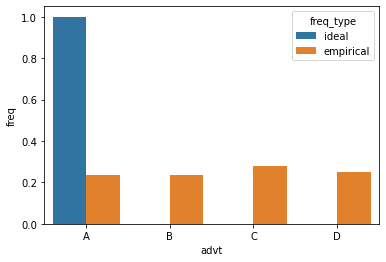

In [45]:
# how many times was each option used? - this is important because it tells us how much time we spent with suboptimal advts
freq_df = pd.DataFrame(columns=['advt', 'freq', 'freq_type'])
# ideally the rel. freq. of the best advt should be 1.0, all else should be 0
best_advt = max(list(advt_ctr.items()), key=lambda t: t[1])[0]
for k in advt_ctr:
    clicks = empirical_clicks.get(k, [])
    temp_freq = 1.0 * len(clicks)/n
    freq_df = freq_df.append({'advt': k, 'freq': 1.0 if k==best_advt else 0.0, 'freq_type':'ideal'}, ignore_index=True)
    freq_df = freq_df.append({'advt': k, 'freq': temp_freq, 'freq_type':'empirical'}, ignore_index=True)

sns.barplot(x="advt", y="freq", hue="freq_type", data=freq_df)



C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\1244712534.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_df = prob_df.append({'Time':i, 'Proportion of Times Pulled':1.0*advts_shown_so_far.count(advt_id)/i, 'advt': advt_id},
C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\1244712534.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_df = prob_df.append({'Time':i, 'Proportion of Times Pulled':1.0*advts_shown_so_far.count(advt_id)/i, 'advt': advt_id},
C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\1244712534.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_df = prob_df.append({'Time':i, 'Proportion of Times Pulled':1.0*advts_shown_so_far.count(advt_id)/i, 'advt': advt_id},
C:\Users\Shub

<AxesSubplot:xlabel='Time', ylabel='Proportion of Times Pulled'>

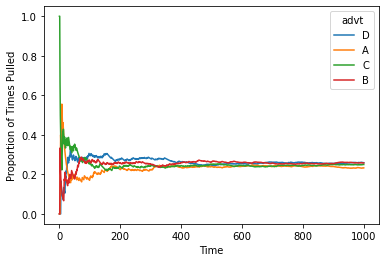

In [64]:
# A standard way to visualize is to see how the probability of picking an action looks like after a given number of trials;
# these are kind of plots we'd be using the most.

def get_prob_at_t(advt_sequence):
    unique_advts = set(advt_sequence)
    prob_df = pd.DataFrame(columns=['Time', 'Proportion of Times Pulled', 'advt'])
    for i in range(1, n+1):
        advts_shown_so_far = advt_sequence[:i]
        for advt_id in unique_advts:
    #         advt_prob_at_t[advt_id].append(1.0*advts_shown_so_far.count(advt_id)/i)
            prob_df = prob_df.append({'Time':i, 'Proportion of Times Pulled':1.0*advts_shown_so_far.count(advt_id)/i, 'advt': advt_id}, 
                                     ignore_index=True)
            #print(prob_df)
    return prob_df
    #i
sns.lineplot(x="Time", y="Proportion of Times Pulled", hue="advt", data=get_prob_at_t(advt_sequence))

In [66]:
# We can also ask what our payoff is. If we assume the same cost for all clicks, this is equivalent to 
# asking "what is the total number of clicks"

def get_total_clicks(empirical_clicks, num_impressions):
    total_clicks = sum([v.count(True) for v in empirical_clicks.values()])
    return total_clicks

print(f"Achieved {100.0*get_total_clicks(empirical_clicks, n)/optimal_number_of_clicks(n)}% clicks.")
    

Best # of impressions per advt, for a total of 1000 impressions.
advt:A (ctr=0.8), optimal impressions: 1000
advt:B (ctr=0.7), optimal impressions: 0
advt:C (ctr=0.1), optimal impressions: 0
advt:D (ctr=0.01), optimal impressions: 0
Achieved 89.375% clicks.


**The story so far**: if we randomly pick an advertisement, we don't learn which is the best. We spend a lot of time serving up advertisements that are suboptimal. This is not the payoff we would like. 

Lets try an epsilon-greedy strategy next.

Best # of impressions per advt, for a total of 1000 impressions.
advt:A (ctr=0.8), optimal impressions: 1000
advt:B (ctr=0.7), optimal impressions: 0
advt:C (ctr=0.1), optimal impressions: 0
advt:D (ctr=0.01), optimal impressions: 0


C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\1244712534.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_df = prob_df.append({'Time':i, 'Proportion of Times Pulled':1.0*advts_shown_so_far.count(advt_id)/i, 'advt': advt_id},
C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\1244712534.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_df = prob_df.append({'Time':i, 'Proportion of Times Pulled':1.0*advts_shown_so_far.count(advt_id)/i, 'advt': advt_id},
C:\Users\Shubham\AppData\Local\Temp\ipykernel_27324\1244712534.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_df = prob_df.append({'Time':i, 'Proportion of Times Pulled':1.0*advts_shown_so_far.count(advt_id)/i, 'advt': advt_id},
C:\Users\Shub

<AxesSubplot:xlabel='Time', ylabel='Proportion of Times Pulled'>

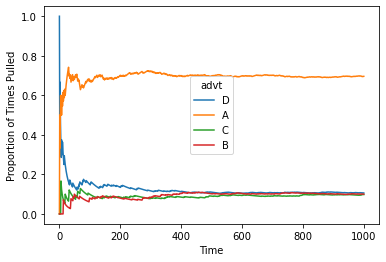

In [69]:
eps=0.4
n=1000
empirical_clicks = defaultdict(list)
advt_sequence = []

def best_so_far(empirical_clicks):
    temp = {}
    for k, v in empirical_clicks.items():
        temp[k] = 1.0 * v.count(True)/len(v)
    return max(temp.items(), key=lambda t:t[1])[0]

# this loop represents our epsilon greedy strategy
for i in range(n):
    explore = True if random.random() <= eps else False
    if i==0 or explore:
        advt_to_show = random.choice(list(advt_ctr.keys())) # we pick a random advt
    else: # exploit
        advt_to_show = best_so_far(empirical_clicks)
    
    was_clicked = show_advt_to_user(advt_to_show)
    advt_sequence.append(advt_to_show)
    empirical_clicks[advt_to_show].append(was_clicked)

    
# lets plot
pct_clicks = 100.0*get_total_clicks(empirical_clicks, n)/optimal_number_of_clicks(n)
sns.lineplot(x="Time", y="Proportion of Times Pulled", hue="advt", data=get_prob_at_t(advt_sequence))#.set_title(f'clicks={pct_clicks}%')



If you play around with different values of epsilon, you'd note:
* small epsilon: a lot rides on your luck - if you chance upon trying suboptimal advts. initially, you'll be stuck with them.
* large epsilon: you will eventually find the best advt., but will spend a lot of money doing it.



In [ ]:
50.0 + 50.0/4